# 微博数据分析

数据包含微博 500 个用户 2020-1-20 到 2020-3-25 号微博正文，包含字段：微博id，微博正文，原始图片url，被转发微博原始图片url，是否为原创微博，微博视频url，发布位置，发布时间，发布工具，点赞数，转发数，评论数


## 导入库/参数设置

In [1]:
import os
import jieba
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [47]:
start_date = "2020-1-20"
font_path = "./Microsoft YaHei Mono.ttf"
media_data_path = "../data/user_data"
stop_words_path = "../data/dictionary/stop_words.txt"
positive_words_path = "../data/dictionary/ntusd-positive.txt"
negative_words_path = "../data/dictionary/ntusd-negative.txt"
expanded_dict_path = "../data/dictionary/jieba_expanded_dict.txt"

In [48]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

## 获取数据

In [23]:
def get_data(file_path):
    total = pd.DataFrame()
    # read all xlsx files
    for root, dirs, files in tqdm(os.walk(file_path)):
        # merge all post
        for file in files:
            df = pd.read_csv(os.path.join(root, file))
            df.drop(columns=["微博id", "原始图片url", "被转发微博原始图片url", "微博视频url", "发布位置", "发布工具"], inplace=True)
            total = total.append(df)
    total.columns = ["post", "is_original", "time", "like", "repost", "comment"]
    total["time"] = pd.to_datetime(total["time"]).dt.date
    total.sort_values("time", inplace=True)
    total.reset_index(drop=True, inplace=True)
    # concatenate posts by date
    # total = total.groupby("time")["post"].sum()
    return total
data = get_data(media_data_path)

501it [00:02, 238.53it/s]


## 查看数据基本信息

In [24]:
data.shape

(11662, 6)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11662 entries, 0 to 11661
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   post         11662 non-null  object
 1   is_original  11662 non-null  bool  
 2   time         11662 non-null  object
 3   like         11662 non-null  int64 
 4   repost       11662 non-null  int64 
 5   comment      11662 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 467.1+ KB


In [ ]:
data[data["is_original"]==True]

In [27]:
data["time"].value_counts()

2020-01-17    213
2020-01-01    200
2020-03-01    195
2020-01-16    191
2020-03-06    185
             ... 
2020-02-16     82
2020-01-30     82
2020-03-30     64
2020-03-28     59
2020-03-31     25
Name: time, Length: 91, dtype: int64

## 每日发布微博数量分布图

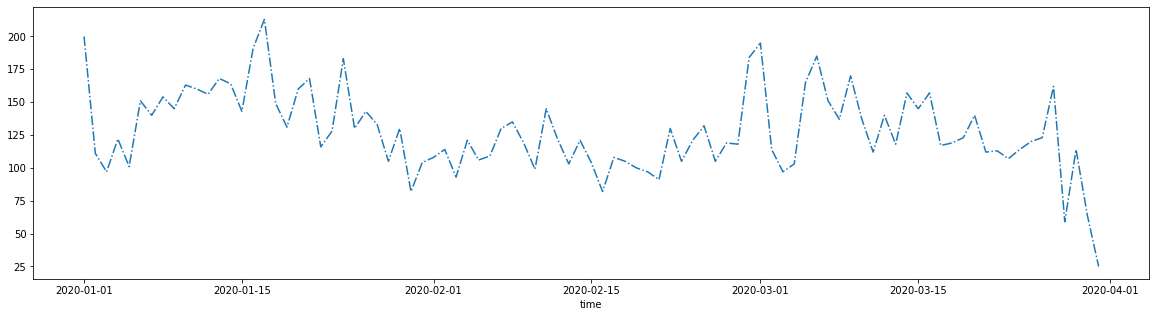

In [28]:
fig1, ax1 = plt.subplots(figsize=(20, 5))
df = data.groupby("time").count()["post"]
df.plot(ax=ax1, style='-.')
plt.show()

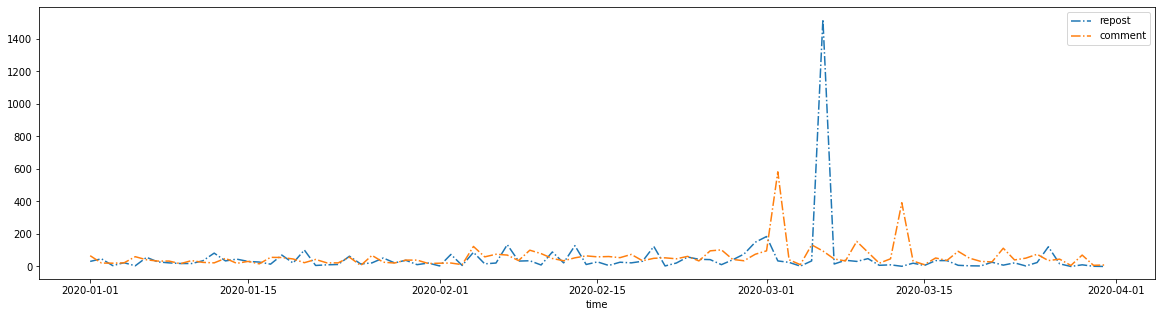

In [29]:
fig2, ax2 = plt.subplots(figsize=(20, 5))
df = data.groupby("time").sum()[["repost", "comment"]]
df.plot(ax=ax2, style='-.')
plt.show()

## 微博正文内容预处理

In [30]:
# only keep chinese text
data["post"] = data["post"].str.replace("[^\u4e00-\u9fa5]","")

In [31]:
# post segmentation
jieba.load_userdict(expanded_dict_path)
data["post"] = data["post"].apply(lambda x: " ".join(jieba.cut(x, cut_all=False)))

In [32]:
# get all kinds of vocabulary
def get_vocab(vocab_path):
    vacab = set()
    with open(vocab_path, encoding="utf-8") as f:
        vocab_list = [x.strip() for x in f.readlines()]
        vacab = set(vocab_list)
    return vacab

## 制作高频词词云

In [33]:
# load stop words
stopwords = get_vocab(stop_words_path)

In [34]:
def gen_wordcloud(text, save_to_file):
    wc = WordCloud(font_path=font_path, width=1000, height=860, scale=2, max_words=100, stopwords=stopwords, background_color="white", collocations=False).generate(text)
    wc.to_file(save_to_file)
    plt.imshow(wc)
    plt.axis("off")

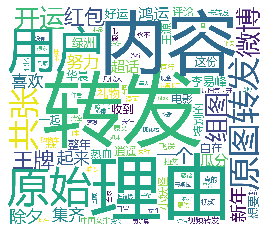

In [35]:
# generate wordcloud by date
date = "2020-1-20"
gen_wordcloud(data.groupby("time")["post"].sum()[pd.to_datetime(date).date()], os.path.join("../data/wordcloud", date + ".png"))

## 获取情绪高频词

In [36]:
positive_words = get_vocab(positive_words_path)
negative_words = get_vocab(negative_words_path)

In [42]:
from collections import Counter
postwords_list = data[data["is_original"]==True].groupby("time")["post"].sum()[pd.to_datetime("2020-1-20").date()].split()
pos_words_list = [word for word in postwords_list if word in positive_words]
neg_words_list = [word for word in postwords_list if word in negative_words]
pos_counter = Counter(pos_words_list)
pos_counter.most_common(10)

[('好运', 23),
 ('喜欢', 21),
 ('特别的', 21),
 ('平安', 8),
 ('健康', 4),
 ('获得', 2),
 ('惊喜', 2),
 ('幸运', 1),
 ('希望', 1),
 ('最高的', 1)]

In [43]:
neg_counter = Counter(neg_words_list)
neg_counter.most_common(10)

[('瓜分', 23),
 ('不是', 2),
 ('何必', 2),
 ('看不惯', 2),
 ('骄傲', 1),
 ('不知道', 1),
 ('疯狂', 1),
 ('争论', 1),
 ('论战', 1),
 ('差别', 1)]

,post,is_original,time,like,repost,comment
1,情绪稳定 是 家人 和 关心 在乎 且 会 哄 我 的 朋友 给 的 礼物 夸 我 棒棒 我...,True,2020-01-01,4,0,0
3,分享 图片 南京 南京 新街口 显示 地图 原图,True,2020-01-01,4,0,0
7,参与 新浪 新闻 年度 娱乐 影响力 人物 评选 助力 爱豆 解锁 年度 霸屏 资源 还有 ...,True,2020-01-01,0,0,0
13,我 在 微博之夜 活动 中为 王一博 陈情 令 的 王一博 投出 了 重要 票 热门 人物 ...,True,2020-01-01,0,0,0
17,希望 能 对 我 宽容一点 西安 显示 地图,True,2020-01-01,2,0,3
...,...,...,...,...,...,...
11646,最近 有病的 人真多,True,2020-03-31,0,0,2
11656,不论 你 现在 是 还是 都 必须 要 认真的 呵护 眼周 肌肤 这是 最能 暴露 你 年龄...,True,2020-03-31,1,0,1
11657,油炸 小 虫虫 三星 的 语音 助手 科技 龙猫 的 秒 拍 视频,True,2020-03-31,0,0,0
11660,女生 睡觉 的 标配 我 我 我 这个 我 必须 参赛 哈哈哈 原图,True,2020-03-31,0,0,0
